In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from orbit.models import DLT
from datetime import timedelta

#  Step 1: Load data 
def read_and_clean(filepath):
    df = pd.read_csv(filepath)
    df.date = pd.to_datetime(df.date)
    df.columns = ['date','PM25','PM10','O3','NO2','SO2','CO']

    df.replace('Missing value', pd.NA, inplace=True)

    df['date'] = pd.to_datetime(df['date'])

    for col in df.columns:
        if col != "date":
            df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.sort_values('date', ascending=True)

    return df

In [79]:
train_df = read_and_clean('data/shanghai-training.csv').dropna()
test_df = read_and_clean('data/shanghai-testing.csv')
city_df = read_and_clean('data/shanghai.csv')

pollutant = 'SO2'

/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_16439/126637747.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.date = pd.to_datetime(df.date)
/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_16439/126637747.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.date = pd.to_datetime(df.date)
/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_16439/126637747.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.date = pd.to_datetime(df.date)


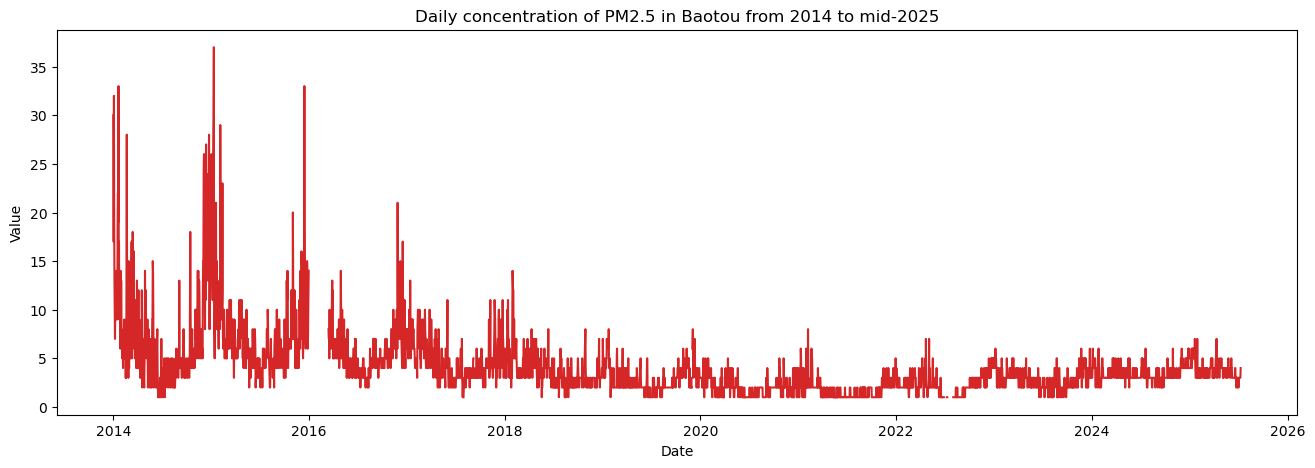

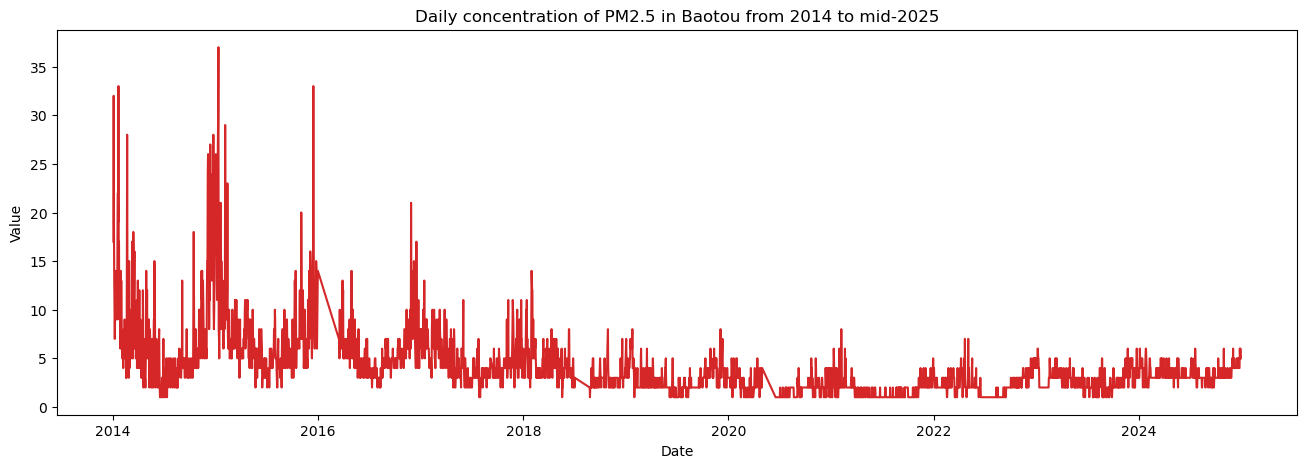

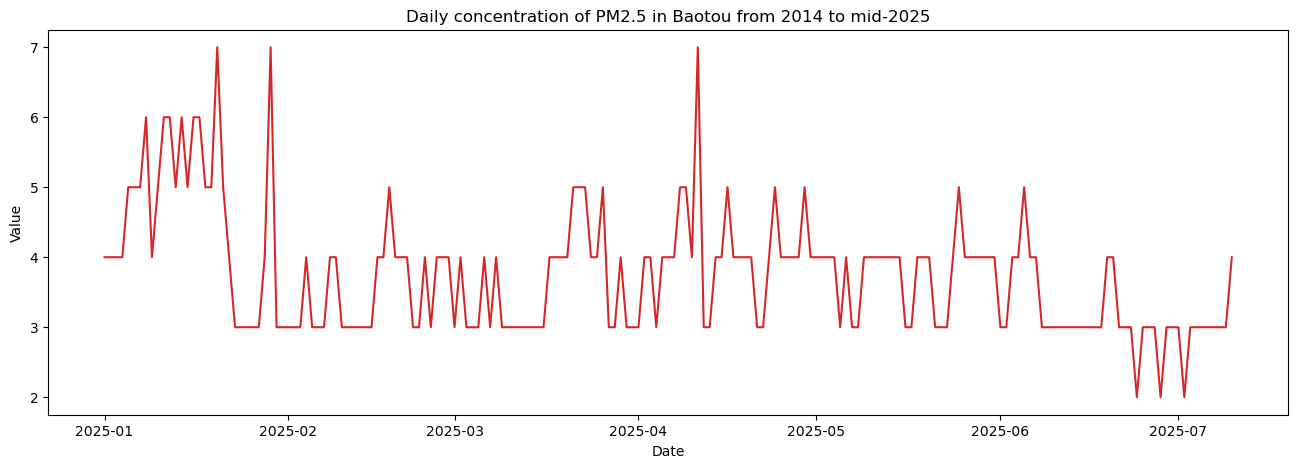

In [80]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value'):
    plt.figure(figsize=(16,5))
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(city_df, x=city_df.date, y=city_df[pollutant], title='Daily concentration of PM2.5 in Baotou from 2014 to mid-2025')
plot_df(train_df, x=train_df.date, y=train_df[pollutant], title='Daily concentration of PM2.5 in Baotou from 2014 to mid-2025')
plot_df(test_df, x=test_df.date, y=test_df[pollutant], title='Daily concentration of PM2.5 in Baotou from 2014 to mid-2025')

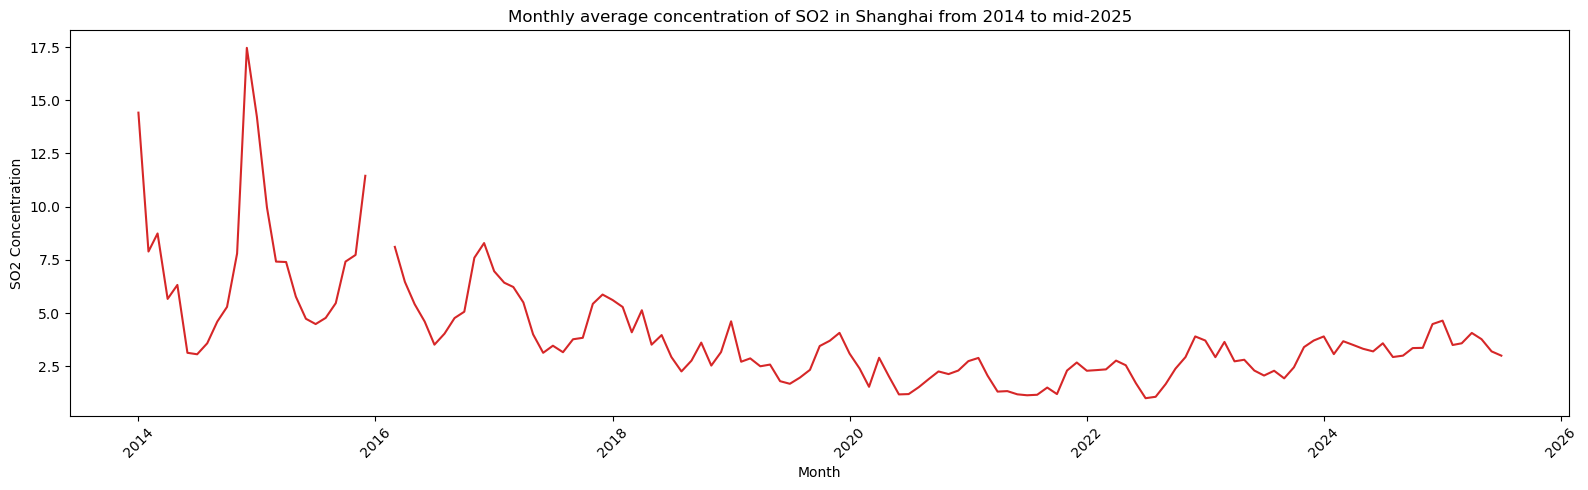

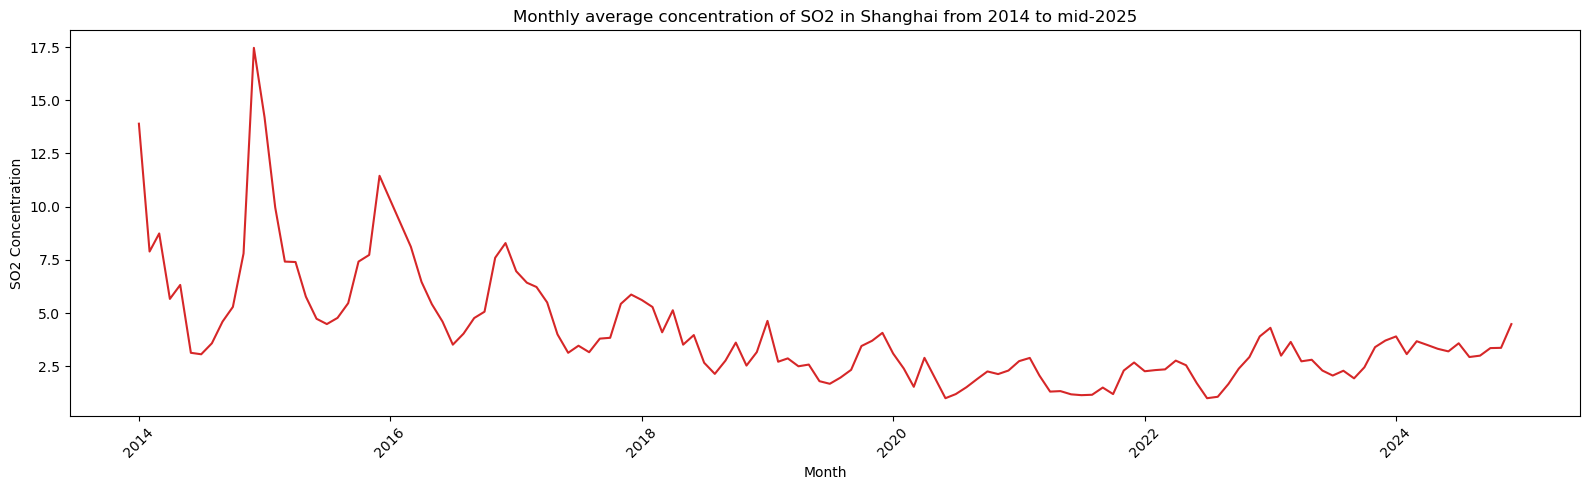

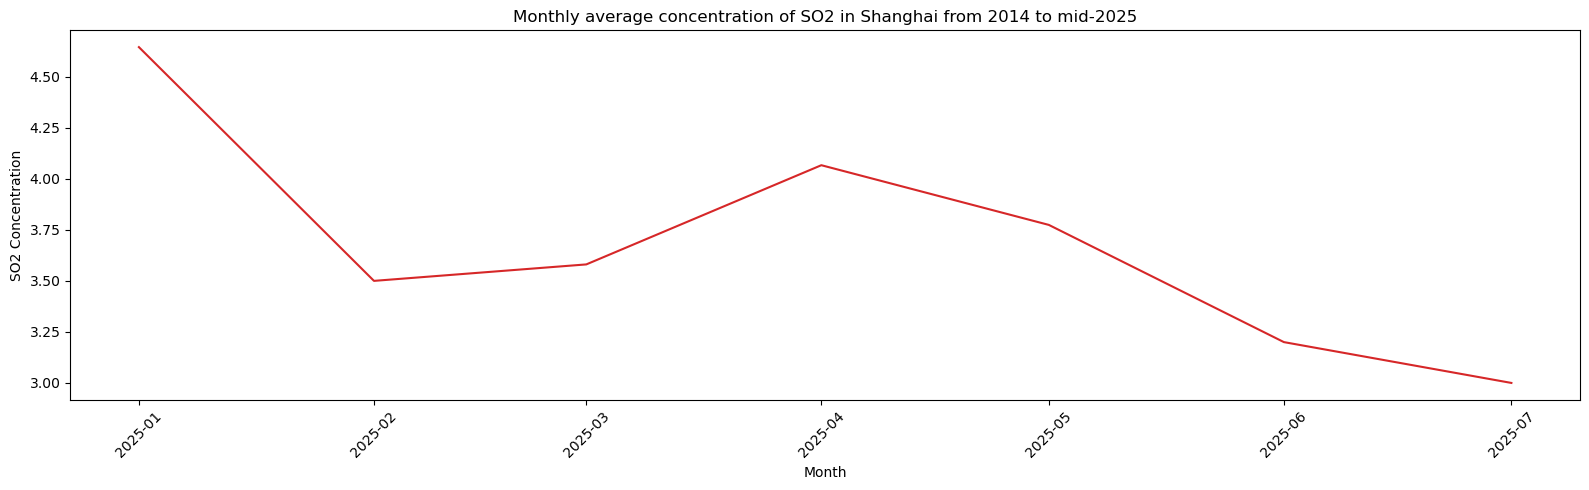

In [81]:
def monthlyAverage(df, city_name, pollutant):
    monthly_df = df.copy()
    monthly_df['year_month'] = monthly_df.date.dt.to_period('M').dt.to_timestamp()

    # Group by the new monthly date
    monthly_avg = monthly_df.groupby('year_month')[pollutant].mean().reset_index()

    def plot_df(x, y, title="", xlabel='Date', ylabel='Value'):
        plt.figure(figsize=(16, 5))
        plt.plot(x, y, color='tab:red')
        plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    plot_df(
        x=monthly_avg['year_month'],
        y=monthly_avg[pollutant],
        title='Monthly average concentration of {pollutant} in {city_name} from 2014 to mid-2025'.format(pollutant=pollutant, city_name=city_name),
        xlabel='Month',
        ylabel='{pollutant} Concentration'.format(pollutant=pollutant)
)

monthlyAverage(city_df, 'Shanghai', pollutant)
monthlyAverage(train_df, 'Shanghai', pollutant)
monthlyAverage(test_df, 'Shanghai', pollutant)

In [82]:
def detect_seasonality(df):
    date_diffs = df['date'].diff().dt.days.dropna()
    median_diff = date_diffs.median()

    if median_diff <= 1.1:
        return 365
    elif median_diff <= 8:
        return 52
    elif median_diff <= 31:
        return 12
    else:
        return 12

seasonality_value = detect_seasonality(train_df)

In [83]:
model = DLT(
    date_col="date",
    response_col=pollutant,
    seasonality=seasonality_value,
    seed=42,
    verbose=1
)

In [84]:
model.fit(train_df)

/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-24 14:42:25 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [85]:
predicted_df = model.predict(test_df)

In [86]:
merged_df = predicted_df.merge(test_df, on="date", how="left")
merged_df = merged_df.rename(columns={pollutant: "actual", "prediction": "predicted"})
merged_df.replace('Missing value', pd.NA, inplace=True)

merged_df = merged_df.dropna()

In [87]:
mae = mean_absolute_error(merged_df["actual"], merged_df["predicted"])

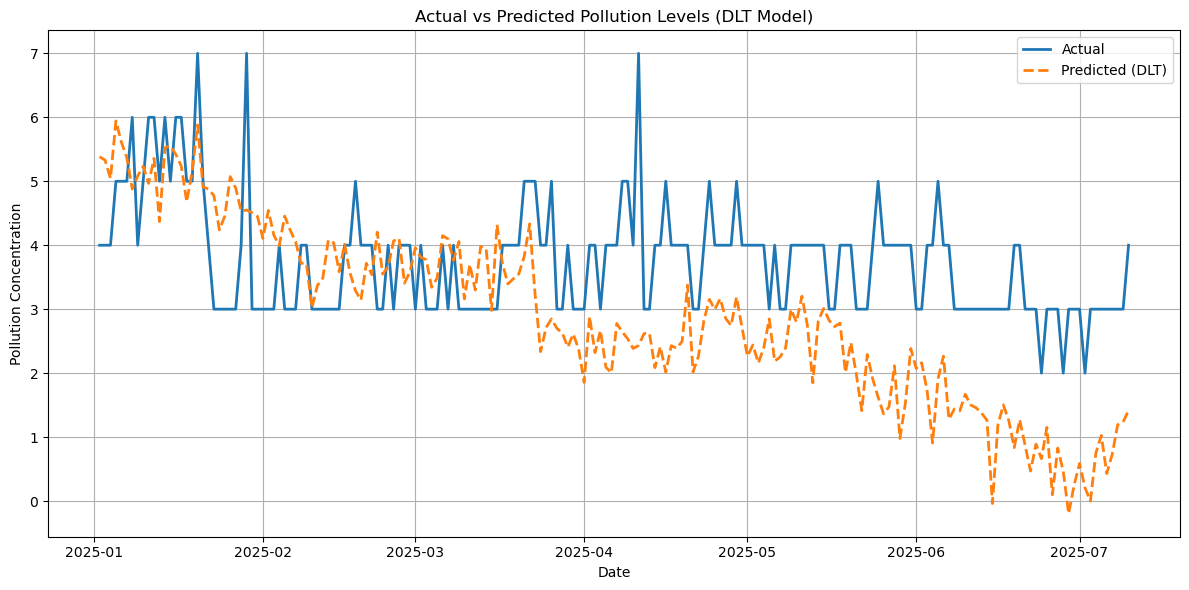

In [88]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df["date"], merged_df["actual"], label="Actual", linewidth=2)
plt.plot(merged_df["date"], merged_df["predicted"], label="Predicted (DLT)", linestyle="--", linewidth=2)
plt.title("Actual vs Predicted Pollution Levels (DLT Model)")
plt.xlabel("Date")
plt.ylabel("Pollution Concentration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [89]:
# Combine
full_df = pd.concat([train_df, test_df], ignore_index=True)

#  Compute Monthly Averages 
monthly_avg = full_df.copy()
monthly_avg['month'] = monthly_avg['date'].dt.month
monthly_profile = monthly_avg.groupby('month')[pollutant].mean().rename('monthly_avg')

#  Add Monthly Average as Regressor 
def add_monthly_regressor(df):
    df = df.copy()
    df['month'] = df['date'].dt.month
    df = df.merge(monthly_profile, left_on='month', right_index=True, how='left')
    return df.drop(columns=['month'])

full_df = add_monthly_regressor(full_df)

# Forecast period
last_date = full_df['date'].max()
end_of_year = pd.Timestamp(f"{last_date.year}-12-31")
n_days = (end_of_year - last_date).days
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_days)
future_df = pd.DataFrame({'date': future_dates})
future_df = add_monthly_regressor(future_df)


In [90]:

#  Fit DLT with Monthly Regressor 
model = DLT(
    date_col="date",
    response_col=pollutant,
    regressor_col=["monthly_avg"],
    seasonality=365,
    seed=42,
    verbose=1
)

model.fit(full_df)

#  Forecast 
print(f"Forecasting through {end_of_year.date()}...")
forecast_df = model.predict(future_df)


/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-24 14:43:29 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Forecasting through 2025-12-31...


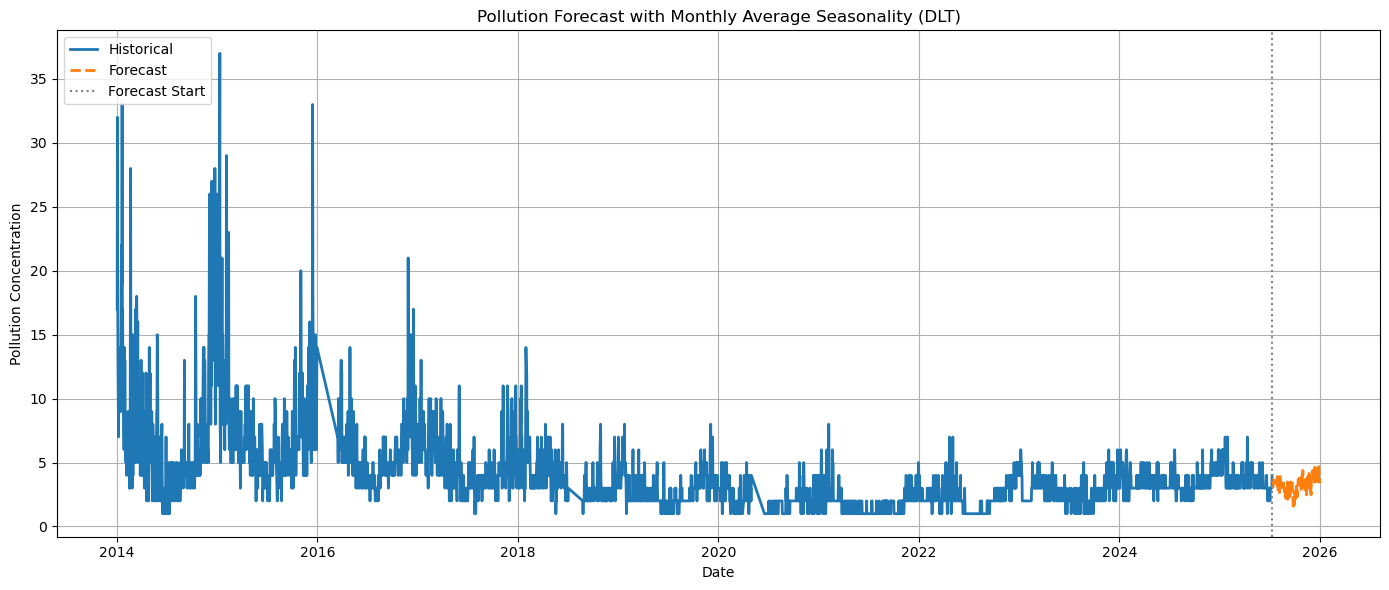

In [91]:

#  Plot 
plt.figure(figsize=(14, 6))
plt.plot(full_df["date"], full_df[pollutant], label="Historical", linewidth=2)
plt.plot(forecast_df["date"], forecast_df["prediction"], label="Forecast", linestyle="--", linewidth=2)
plt.axvline(last_date, color='gray', linestyle=':', label="Forecast Start")
plt.title("Pollution Forecast with Monthly Average Seasonality (DLT)")
plt.xlabel("Date")
plt.ylabel("Pollution Concentration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [92]:
from datetime import datetime

#  Update forecast horizon 
forecast_horizon = pd.date_range(
    start=last_date + timedelta(days=1),
    end=pd.Timestamp("2030-12-31"),
    freq='D'
)

# Create future DataFrame and assign monthly average
future_df_long = pd.DataFrame({'date': forecast_horizon})
future_df_long = add_monthly_regressor(future_df_long)


In [93]:

#  Retrain model on full dataset with monthly regressor 
model = DLT(
    date_col="date",
    response_col=pollutant,
    regressor_col=["monthly_avg"],
    seasonality=365,
    seed=42,
    verbose=1
)

print("Fitting DLT on full data for long-term forecasting...")
model.fit(full_df)

#  Predict future pollution levels to 2030 
print("Forecasting until 2030-12-31...")
#  Forecast with prediction intervals 
forecast_long_df = model.predict(future_df_long, include_ci=True)


/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-24 14:45:24 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


Fitting DLT on full data for long-term forecasting...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Forecasting until 2030-12-31...


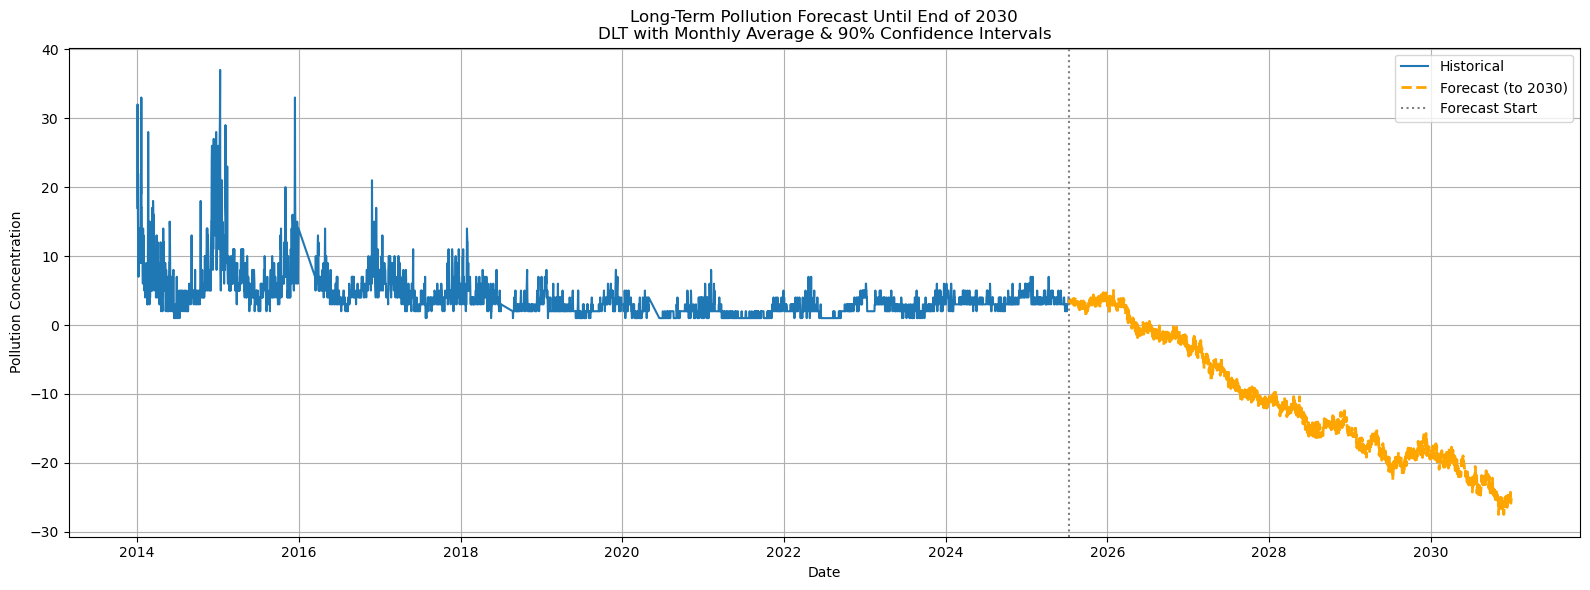

In [94]:

#  Plot 
plt.figure(figsize=(16, 6))
plt.plot(full_df["date"], full_df[pollutant], label="Historical", linewidth=1.5)
plt.plot(forecast_long_df["date"], forecast_long_df["prediction"],
         label="Forecast (to 2030)", linestyle="--", linewidth=2, color='orange')

plt.axvline(last_date, color='gray', linestyle=':', label="Forecast Start")
plt.title("Long-Term Pollution Forecast Until End of 2030\nDLT with Monthly Average & 90% Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Pollution Concentration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [95]:
import numpy as np

#  Parameters 
forecast_start = pd.to_datetime(last_date)
decay_rate = 0.02  # Decay rate per year (adjust to control intensity)

#  Compute decay factor 
days_since_start = (forecast_long_df["date"] - forecast_start).dt.days
years_since_start = days_since_start / 365.25
decay_factor = np.exp(-decay_rate * years_since_start)

#  Apply decay to forecast and confidence intervals 
forecast_long_df["prediction_decay"] = forecast_long_df["prediction"] * decay_factor
forecast_long_df["prediction_5_decay"] = forecast_long_df["prediction_5"] * decay_factor
forecast_long_df["prediction_95_decay"] = forecast_long_df["prediction_95"] * decay_factor

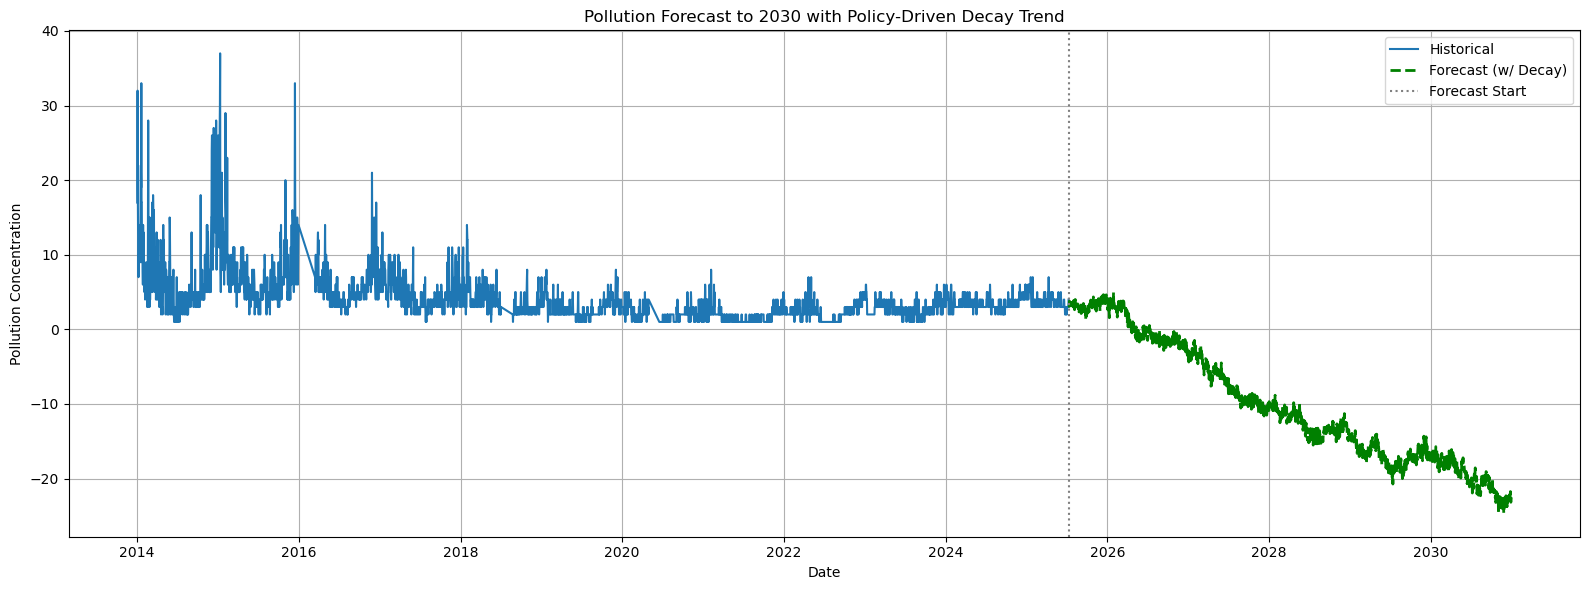

In [96]:
plt.figure(figsize=(16, 6))
plt.plot(full_df["date"], full_df[pollutant], label="Historical", linewidth=1.5)
plt.plot(forecast_long_df["date"], forecast_long_df["prediction_decay"],
         label="Forecast (w/ Decay)", linestyle="--", linewidth=2, color='green')

plt.axvline(forecast_start, color='gray', linestyle=':', label="Forecast Start")
plt.title("Pollution Forecast to 2030 with Policy-Driven Decay Trend")
plt.xlabel("Date")
plt.ylabel("Pollution Concentration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-24 14:47:15 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


Fitting DLT on full data with decay trend...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Forecasting until 2030-12-31 with decay trend...


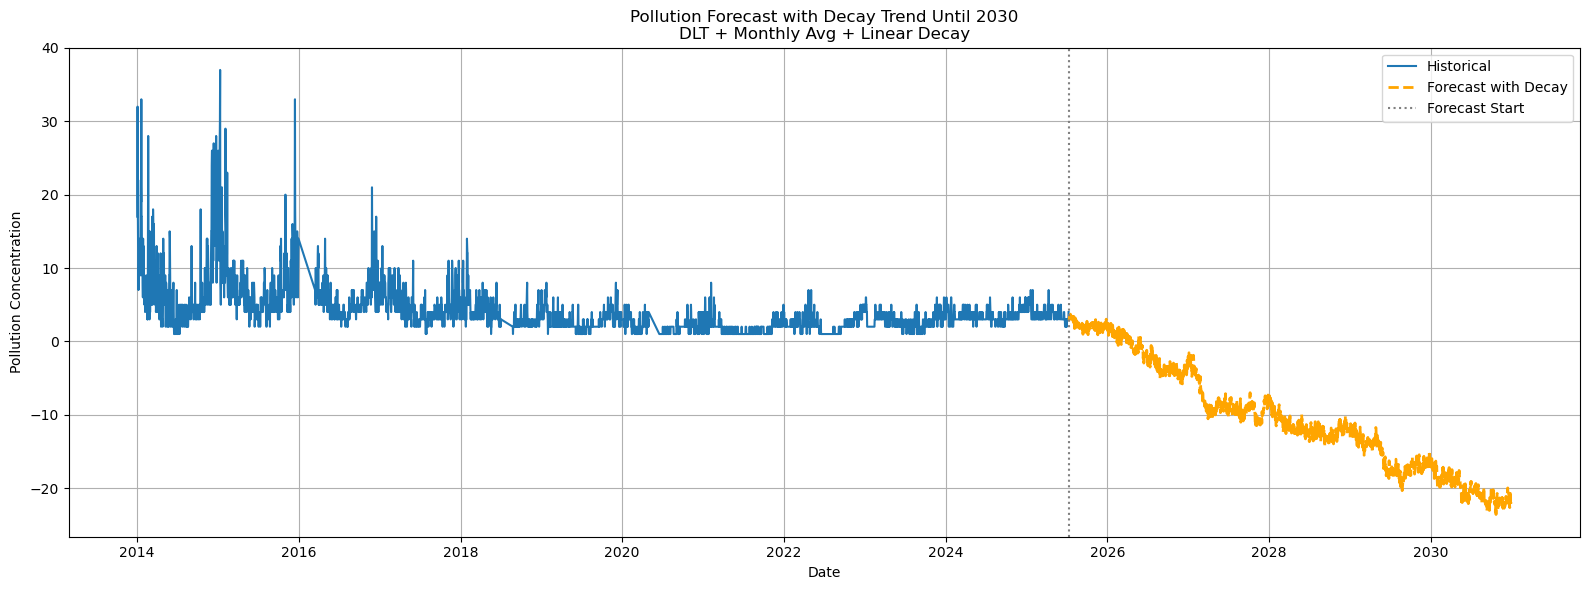

In [97]:
from datetime import datetime, timedelta
import numpy as np

#  Update forecast horizon 
forecast_horizon = pd.date_range(
    start=last_date + timedelta(days=1),
    end=pd.Timestamp("2030-12-31"),
    freq='D'
)

#  Create future DataFrame 
future_df_long = pd.DataFrame({'date': forecast_horizon})
future_df_long = add_monthly_regressor(future_df_long)

#  Add decay regressor (linearly decreasing from 1 to 0) 
total_days = (future_df_long['date'].max() - future_df_long['date'].min()).days
future_df_long['decay_trend'] = np.linspace(1, 0, total_days + 1)

#  Also add decay to historical data (linearly from 1 to point of forecast start) 
historical_days = (full_df['date'].max() - full_df['date'].min()).days
full_df['decay_trend'] = np.linspace(1, 1 - (len(full_df) / (len(full_df) + len(future_df_long))), len(full_df))

#  Retrain model with decay trend 
model = DLT(
    date_col="date",
    response_col=pollutant,
    regressor_col=["monthly_avg", "decay_trend"],
    seasonality=365,
    seed=42,
    verbose=1
)

print("Fitting DLT on full data with decay trend...")
model.fit(full_df)

#  Forecast 
print("Forecasting until 2030-12-31 with decay trend...")
forecast_long_df = model.predict(future_df_long, include_ci=True)

#  Plot 
plt.figure(figsize=(16, 6))
plt.plot(full_df["date"], full_df[pollutant], label="Historical", linewidth=1.5)
plt.plot(forecast_long_df["date"], forecast_long_df["prediction"],
         label="Forecast with Decay", linestyle="--", linewidth=2, color='orange')
plt.axvline(last_date, color='gray', linestyle=':', label="Forecast Start")
plt.title("Pollution Forecast with Decay Trend Until 2030\nDLT + Monthly Avg + Linear Decay")
plt.xlabel("Date")
plt.ylabel("Pollution Concentration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-24 14:49:05 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


Fitting DLT on full data with decay trend...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Forecasting until 2030-12-31 with decay trend...


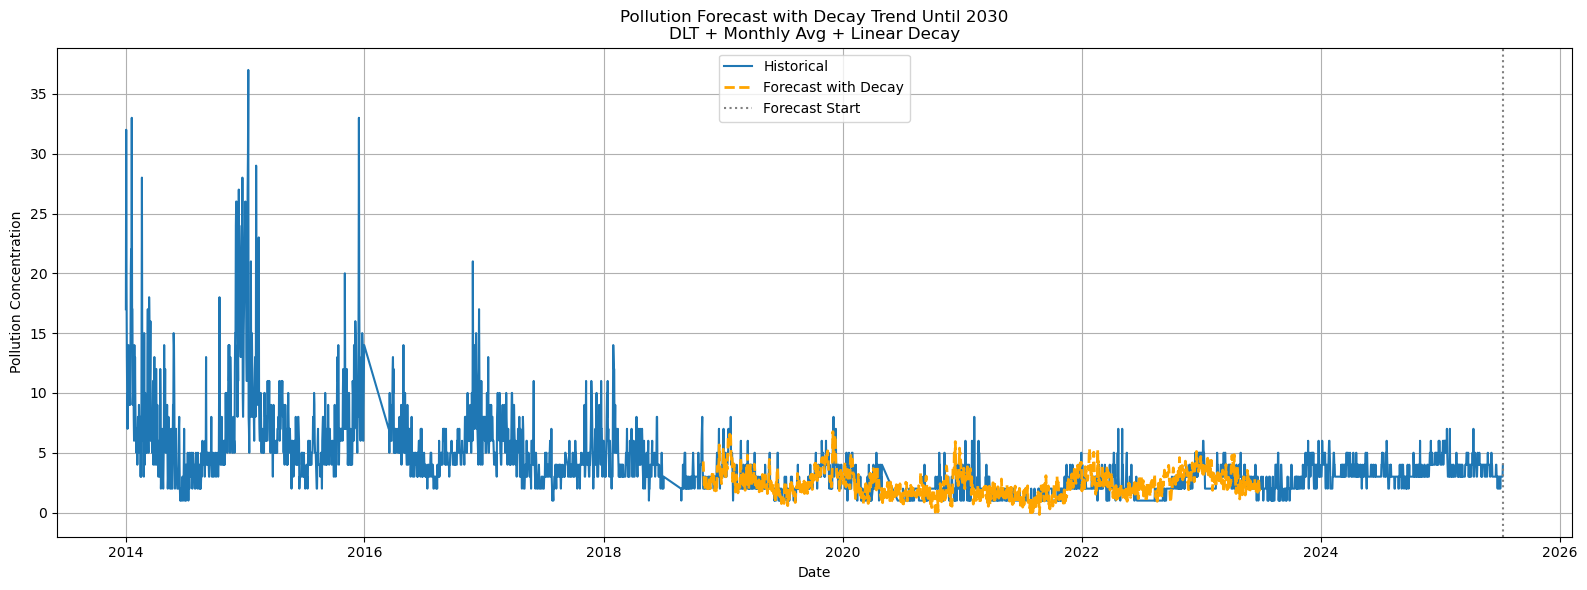

In [98]:
from datetime import datetime, timedelta
import numpy as np

#  Update forecast horizon 
forecast_horizon = pd.date_range(
    start=pd.Timestamp("2018-10-31") + timedelta(days=1),
    end=pd.Timestamp("2023-06-30"),
    freq='D'
)

#  Create future DataFrame 
future_df_long = pd.DataFrame({'date': forecast_horizon})
future_df_long = add_monthly_regressor(future_df_long)

#  Add decay regressor (linearly decreasing from 1 to 0) 
total_days = (future_df_long['date'].max() - future_df_long['date'].min()).days
future_df_long['decay_trend'] = np.linspace(1, 0, total_days + 1)

#  Also add decay to historical data (linearly from 1 to point of forecast start) 
historical_days = (full_df['date'].max() - full_df['date'].min()).days
full_df['decay_trend'] = np.linspace(1, 1 - (len(full_df) / (len(full_df) + len(future_df_long))), len(full_df))

#  Retrain model with decay trend 
model = DLT(
    date_col="date",
    response_col=pollutant,
    regressor_col=["monthly_avg", "decay_trend"],
    seasonality=365,
    seed=42,
    verbose=1
)

print("Fitting DLT on full data with decay trend...")
model.fit(full_df)

#  Forecast 
print("Forecasting until 2030-12-31 with decay trend...")
forecast_long_df = model.predict(future_df_long, include_ci=True)

#  Plot 
plt.figure(figsize=(16, 6))
plt.plot(full_df["date"], full_df[pollutant], label="Historical", linewidth=1.5)
plt.plot(forecast_long_df["date"], forecast_long_df["prediction"],
         label="Forecast with Decay", linestyle="--", linewidth=2, color='orange')
plt.axvline(last_date, color='gray', linestyle=':', label="Forecast Start")
plt.title("Pollution Forecast with Decay Trend Until 2030\nDLT + Monthly Avg + Linear Decay")
plt.xlabel("Date")
plt.ylabel("Pollution Concentration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [99]:
full_df

,date,PM25,PM10,O3,NO2,SO2,CO,monthly_avg,decay_trend
0,2014-01-02,188.0,92.0,39.0,54.0,17.0,13.0,6.097484,1.000000
1,2014-01-03,170.0,105.0,21.0,55.0,32.0,12.0,6.097484,0.999823
2,2014-01-04,191.0,94.0,18.0,36.0,19.0,9.0,6.097484,0.999645
3,2014-01-05,176.0,53.0,13.0,37.0,13.0,7.0,6.097484,0.999468
4,2014-01-06,116.0,36.0,28.0,28.0,10.0,7.0,6.097484,0.999290
...,...,...,...,...,...,...,...,...,...
3929,2025-07-07,51.0,15.0,25.0,4.0,3.0,4.0,2.676871,0.302821
3930,2025-07-08,27.0,18.0,20.0,4.0,3.0,4.0,2.676871,0.302643
3931,2025-07-09,26.0,21.0,23.0,4.0,3.0,4.0,2.676871,0.302466
3932,2025-07-10,38.0,40.0,18.0,5.0,4.0,4.0,2.676871,0.302288


In [119]:
from orbit.models import DLT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

#  Step 0: Assumes full_df and monthly_profile are already defined 

# If 'date' is in the index instead of a column
if 'date' not in full_df.columns and full_df.index.name == 'date':
    full_df.reset_index(inplace=True)

# Step 1: Forecast horizon
last_date = full_df['date'].max()
forecast_horizon = pd.date_range(start=last_date + timedelta(days=1), end=pd.Timestamp("2030-12-31"), freq='D')
future_df = pd.DataFrame({'date': forecast_horizon})

# Step 2: Add monthly regressor safely
def add_monthly_regressor(df):
    df = df.copy()
    if 'monthly_avg' in df.columns:
        df.drop(columns=['monthly_avg'], inplace=True)
    df['month'] = df['date'].dt.month
    df = df.merge(monthly_profile, left_on='month', right_index=True, how='left')
    return df.drop(columns=['month'])

full_df = add_monthly_regressor(full_df)
future_df = add_monthly_regressor(future_df)

# Step 3: Add decay trend
def create_decay_trend(length, start=1.0, end=0.001):
    return np.linspace(start, end, length)

full_df['decay_trend'] = create_decay_trend(len(full_df))
future_df['decay_trend'] = create_decay_trend(len(future_df), start=full_df['decay_trend'].iloc[-1])

# Step 4: Add feature engineering
def add_engineered_features(df):
    df = df.copy()
    df['monthly_avg_std'] = (df['monthly_avg'] - df['monthly_avg'].mean()) / df['monthly_avg'].std()
    df['decay_log'] = np.log(df['decay_trend'].clip(lower=1e-5))
    df['monthly_avg_ma7'] = df['monthly_avg'].rolling(window=7, min_periods=1).mean()
    return df

full_df = add_engineered_features(full_df)
future_df = add_engineered_features(future_df)

# Step 5: Fit model
model = DLT(
    date_col="date",
    response_col=pollutant,  # must be defined beforehand
    regressor_col=["monthly_avg_std", "decay_log", "monthly_avg_ma7"],
    regressor_sign=["+", "-", "+"],
    seasonality=365,
    seed=42,
    verbose=1,
    estimator="stan-mcmc",
    global_trend_option="flat",
    regression_penalty="auto_ridge",
    prediction_percentiles=[5, 50, 95]
)

print("Fitting the model...")
model.fit(full_df)

# Step 6: Forecast
print("Forecasting until 2030-12-31...")
forecast_df = model.predict(future_df, include_ci=True)

# Step 7: Clip for safety
for col in ["prediction", "prediction_5", "prediction_95"]:
    forecast_df[col] = forecast_df[col].clip(lower=0)


/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-24 14:59:37 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


Fitting the model...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Forecasting until 2030-12-31...


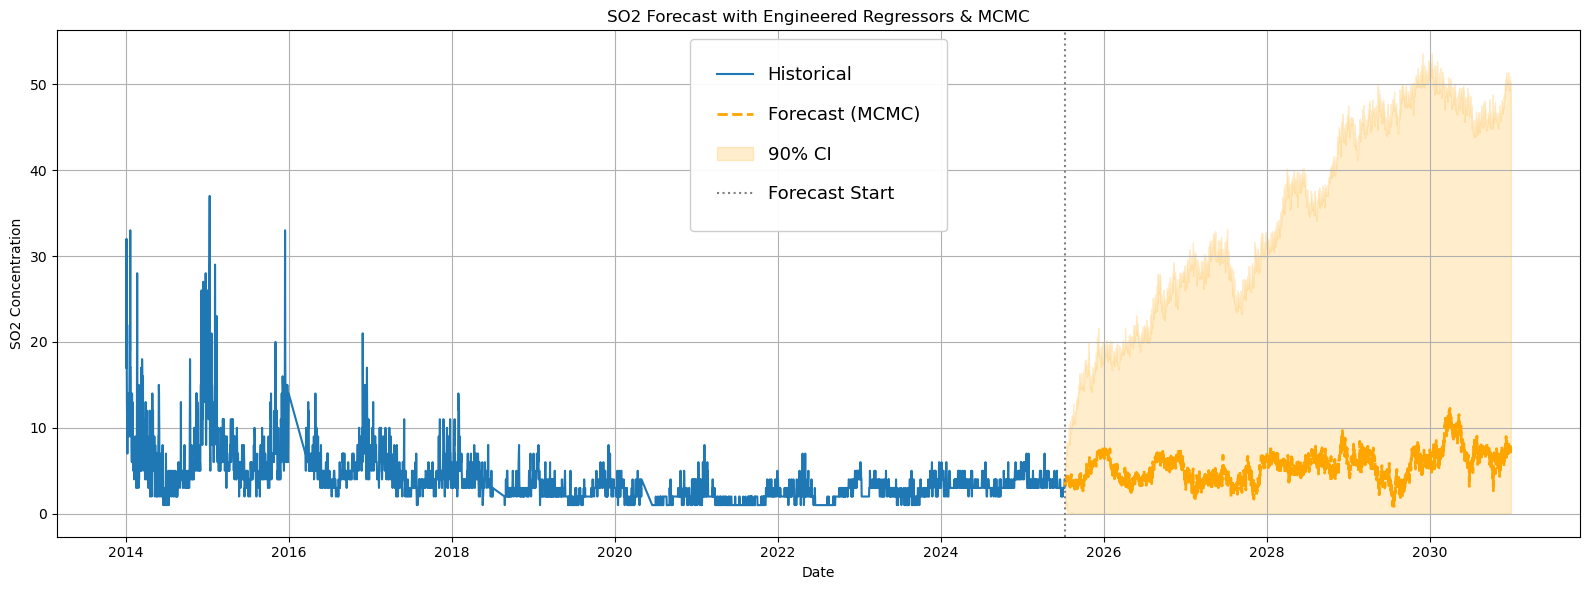

In [101]:
# Step 8: Plot
plt.figure(figsize=(16, 6))
plt.plot(full_df["date"], full_df[pollutant], label="Historical", linewidth=1.5)
plt.plot(forecast_df["date"], forecast_df["prediction"], label="Forecast (MCMC)", linestyle="--", linewidth=2, color='orange')
plt.fill_between(forecast_df["date"], forecast_df["prediction_5"], forecast_df["prediction_95"], color='orange', alpha=0.2, label="90% CI")
plt.axvline(last_date, color='gray', linestyle=':', label="Forecast Start")

plt.title(f"{pollutant} Forecast with Engineered Regressors & MCMC")
plt.xlabel("Date")
plt.ylabel(f"{pollutant} Concentration")

# Enhanced legend for visibility
plt.legend(
    fontsize=13,
    loc='best',           # Automatically chooses best location inside plot
    frameon=True,
    fancybox=True,
    framealpha=0.95,
    borderpad=1.5,
    labelspacing=1.2
)

plt.grid(True)
plt.tight_layout()
plt.show()

In [120]:

# Step 9: Combine historical and forecast

historical = full_df[["date", pollutant]].copy()
historical["is_forecast"] = False

forecast_output = forecast_df[["date", "prediction", "prediction_5", "prediction_95"]].copy()
forecast_output = forecast_output.rename(columns={
    "prediction": pollutant,
    "prediction_5": f"{pollutant}_lower",
    "prediction_95": f"{pollutant}_upper"
})
forecast_output["is_forecast"] = True


In [103]:
# Combine
combined_df = pd.concat([historical, forecast_output], ignore_index=True)

# Optional: Save to file
combined_df.to_csv(f"{pollutant}_forecast_combined.csv", index=False)
print(f"Forecast data saved to '{pollutant}_forecast_combined.csv'")

Forecast data saved to 'SO2_forecast_combined.csv'


In [125]:
forecast_df = pd.read_csv(f'{pollutant}_forecast_combined.csv')
forecast_df.date = pd.to_datetime(forecast_df.date)
forecast_df.columns = ['date', pollutant ,'is_forecast',f'{pollutant}_lower',f'{pollutant}_upper']

forecast_df.replace('Missing value', pd.NA, inplace=True)

forecast_df['date'] = pd.to_datetime(forecast_df['date'])
forecast_df[pollutant] = pd.to_numeric(forecast_df[pollutant], errors='coerce')
forecast_df['prediction'] = forecast_df[f'{pollutant}'].where(forecast_df['is_forecast'])

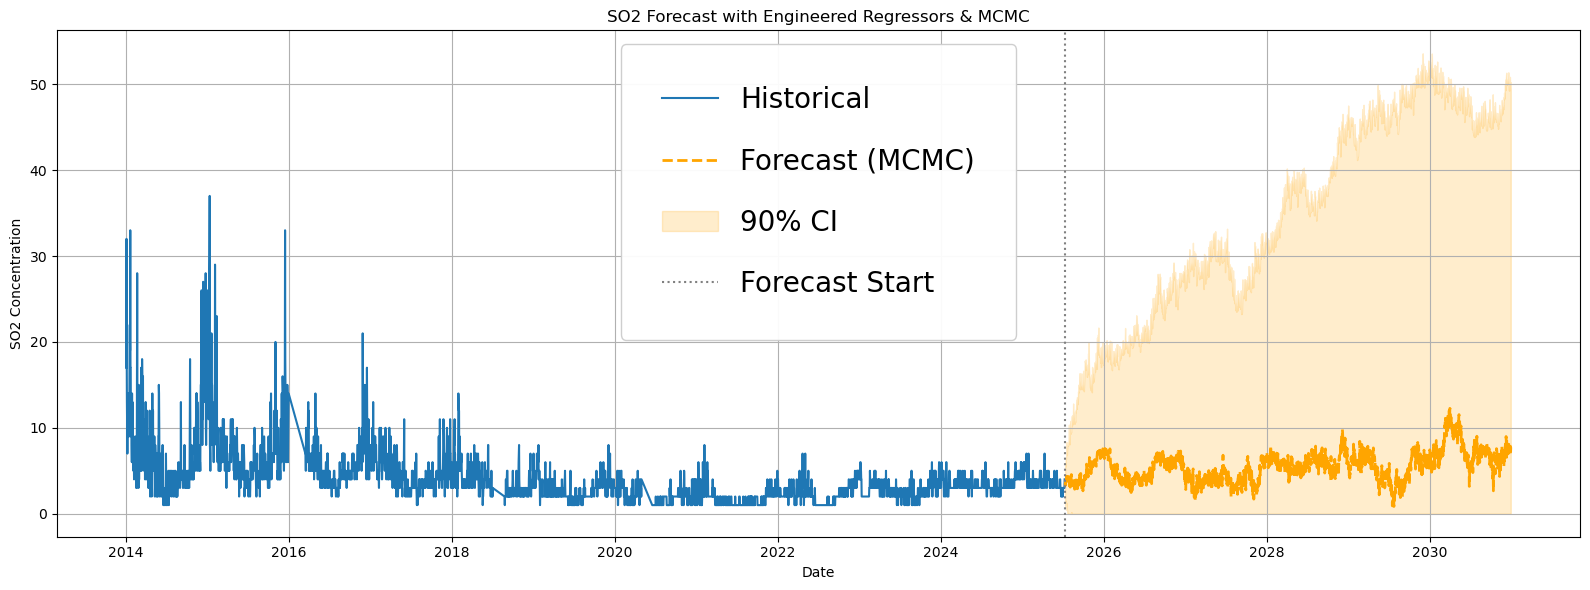

In [127]:
plt.figure(figsize=(16, 6))
plt.plot(full_df["date"], full_df[pollutant], label="Historical", linewidth=1.5)
plt.plot(forecast_df["date"], forecast_df['prediction'], label="Forecast (MCMC)", linestyle="--", linewidth=2, color='orange')
plt.fill_between(forecast_df["date"], forecast_df[f'{pollutant}_lower'], forecast_df[f'{pollutant}_upper'], color='orange', alpha=0.2, label="90% CI")
plt.axvline(last_date, color='gray', linestyle=':', label="Forecast Start")
plt.title(f"{pollutant} Forecast with Engineered Regressors & MCMC")
plt.xlabel("Date")
plt.ylabel(f"{pollutant} Concentration")

# Enhanced legend for visibility
plt.legend(
    fontsize=20,
    loc='best',           # Automatically chooses best location inside plot
    frameon=True,
    fancybox=True,
    framealpha=0.95,
    borderpad=1.5,
    labelspacing=1.2
)

plt.grid(True)
plt.tight_layout()
plt.show()

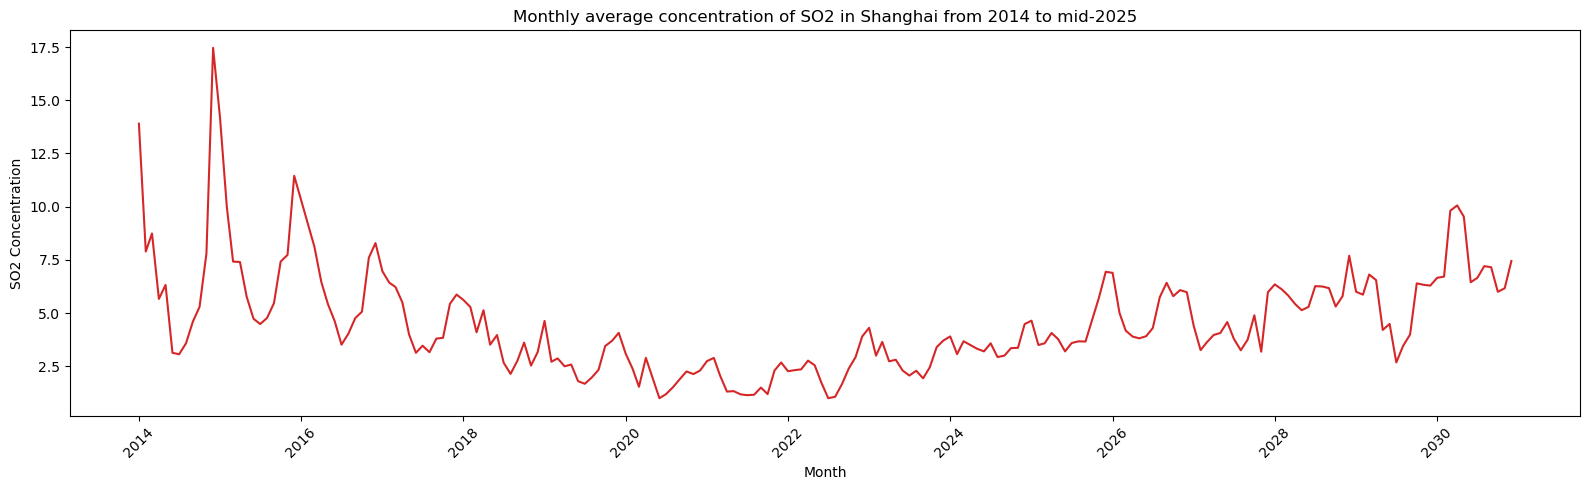

In [128]:
monthlyAverage(forecast_df, 'Shanghai', pollutant)

In [107]:
pred_df = model.predict(full_df, include_ci=True)

coverage = ((full_df[pollutant] >= pred_df["prediction_5"]) & (full_df[pollutant] <= pred_df["prediction_95"])).mean()
print(f"Prediction interval coverage (should be ~0.90): {coverage:.3f}")


Prediction interval coverage (should be ~0.90): 0.877


/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:335: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


In [108]:
import numpy as np
import pandas as pd
from orbit.models import DLT
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

def smape(a, f):
    return 100 * np.mean(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

# Configuration
horizon = 30
n_splits = 5
total_len = len(full_df)
split_size = (total_len - horizon) // n_splits

scores = []

for i in range(n_splits):
    train_end = (i + 1) * split_size
    train_df = full_df.iloc[:train_end]
    test_df = full_df.iloc[train_end:train_end + horizon]

    model_cv = DLT(
        date_col="date",
        response_col=pollutant,
        regressor_col=["monthly_avg_std", "decay_log", "monthly_avg_ma7"],
        regressor_sign=["+", "-", "+"],
        seasonality=365,
        seed=42,
        estimator="stan-mcmc",
        global_trend_option="flat",
        regression_penalty="auto_ridge",
        prediction_percentiles=[5, 50, 95]
    )
    model_cv.fit(train_df)
    pred_df = model_cv.predict(test_df, include_ci=False)

    mae = mean_absolute_error(test_df[pollutant], pred_df["prediction"])
    smp = smape(test_df[pollutant], pred_df["prediction"])
    scores.append({"split": i + 1, "MAE": mae, "SMAPE": smp})

# Summary
scores_df = pd.DataFrame(scores)
print("Cross-Validation Results:")
print(scores_df)
print("\nOverall MAE:", scores_df["MAE"].mean())
print("Overall SMAPE:", scores_df["SMAPE"].mean())

/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-24 14:53:05 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-24 14:53:17 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-24 14:53:46 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:335: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-24 14:54:33 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-24 14:55:41 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Cross-Validation Results:
   split       MAE  SMAPE
0      1  1.512511    NaN
1      2  0.790953    NaN
2      3  1.203498    NaN
3      4  0.839971    NaN
4      5  1.421818    NaN

Overall MAE: 1.1537502830180935
Overall SMAPE: nan


/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:335: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


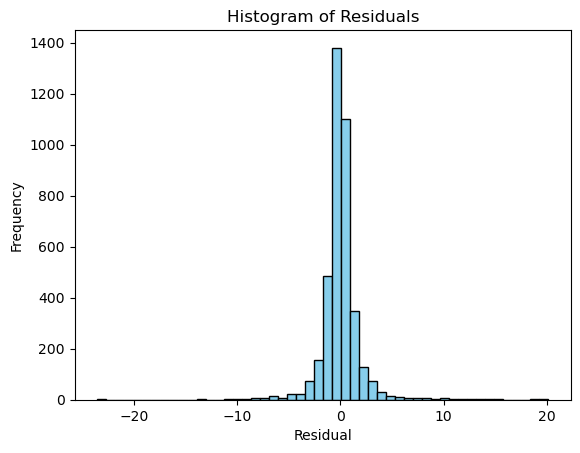

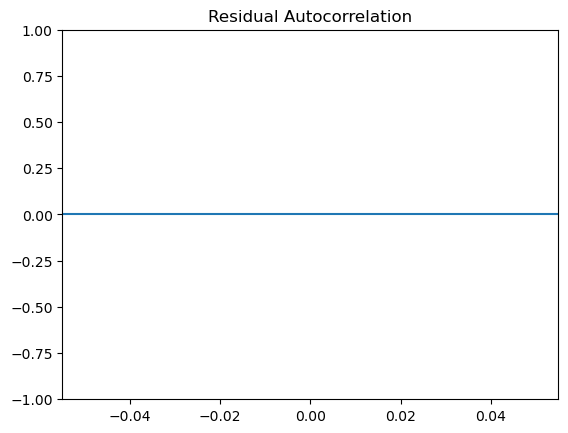

In [109]:
predicted = model.predict(full_df)
residuals = full_df[pollutant] - predicted["prediction"]

# Residual distribution
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Autocorrelation in residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=40)
plt.title("Residual Autocorrelation")
plt.show()

In [110]:
from statsmodels.stats.diagnostic import acorr_ljungbox
clean_residuals = residuals.dropna()
lb_test = acorr_ljungbox(clean_residuals, lags=[5], return_df=True)
print(lb_test)

      lb_stat     lb_pvalue
5  455.154205  3.796960e-96


This means that the residuals are autocorrelated. The null hypothesis is rejected. The model did not fully capture the underlying temporal patterns in the data, so it's missing lag effects, or structural shift.

In [111]:
coverage = ((full_df[pollutant] >= predicted["prediction_5"]) & (full_df[pollutant] <= predicted["prediction_95"])).mean()
print(f"Empirical 90% interval coverage: {coverage:.2%}")

Empirical 90% interval coverage: 88.10%


In [112]:
def detect_anomalies(pred_df, actual_df, value_col, low_col="prediction_5", high_col="prediction_95"):
    merged = pred_df[["date", low_col, "prediction", high_col]].merge(
        actual_df[["date", value_col]], on="date", how="left"
    )
    merged["anomaly"] = (merged[value_col] < merged[low_col]) | (merged[value_col] > merged[high_col])
    return merged

In [113]:
def plot_anomaly_detection(anomalies_df, value_col):
    plt.figure(figsize=(15, 6))
    plt.plot(anomalies_df["date"], anomalies_df[value_col], label="Actual", color="blue")
    plt.plot(anomalies_df["date"], anomalies_df["prediction"], label="Forecast", color="orange")
    plt.fill_between(anomalies_df["date"], anomalies_df["prediction_5"], anomalies_df["prediction_95"],
                     color="gray", alpha=0.3, label="Confidence Interval")

    anomaly_points = anomalies_df[anomalies_df["anomaly"]]
    plt.scatter(anomaly_points["date"], anomaly_points[value_col], color="red", label="Anomaly", zorder=5)

    plt.title(f"Multivariate Anomaly Detection for {value_col}")
    plt.xlabel("Date")
    plt.ylabel("Pollution Level")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [114]:
# You can adjust the split point
split_date = pd.to_datetime("2023-01-01")
train_df = full_df[full_df["date"] < split_date]
test_df = full_df[full_df["date"] >= split_date]


/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-24 14:57:24 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


Backtest: refitting model for anomaly detection...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Generating backtest forecast...
Detecting anomalies...
Plotting anomaly results...


/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:335: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


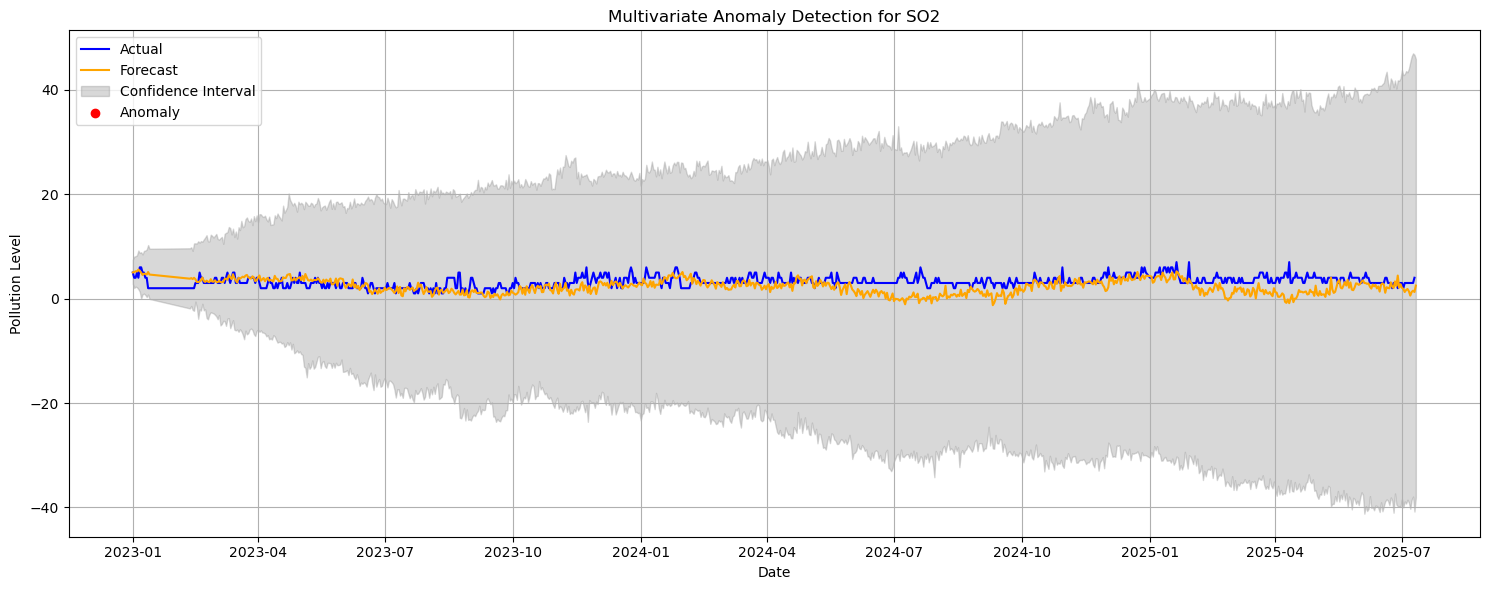

In [115]:
print("Backtest: refitting model for anomaly detection...")
model.fit(train_df)

print("Generating backtest forecast...")
historical_pred_df = model.predict(test_df, include_ci=True)

print("Detecting anomalies...")
anomaly_results = detect_anomalies(historical_pred_df, test_df, value_col=pollutant)

print("Plotting anomaly results...")
plot_anomaly_detection(anomaly_results, value_col=pollutant)

## NOT GOOD FOR ANOMALY!